<a href="https://colab.research.google.com/github/kimkynningsrud/MasterThesis2024/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning using DTW - Master Thesis 2024

To do:
  - Implement other functions to measure dataset similarity
    - Look at ccf? Find some other metrics.
  - Make/change model to fine tune outer layer to target dataset
  - Implement metrics for transfer learning from Fadi's paper  

What this code does:
  - Imports all datasets and puts them in a dictionary
  - Preprocessing (sets datetime, removing Nan, slicing to relevant timeframe, ensures each ts the same amount of observations etc.)
  - Dynamic Time Warping (DTW) for all datasets in dictionary
  - Finds Cross-correlation for all datasets in dictionary
  - Splits all datasets into train and test sets.
  - Creates machine learning models (RNN, MLP) and trains on all train sets and predicts for all test sets.


Questions:
  - Removes 'Date' in the training data. The order is preserved. Is this the correct approach, or is it better to transform them into numerical features?
  - As of now, the models use single-source transfer (train on source data, predict on target data). With justification, consider:
    - Possibly use multi-source transfer instead (train model on multiple source datasets)?
    - Combine different models trained by one dataset, and finetune it to target, like Fadi's paper.
  

## Importing Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#pip install dtaidistance
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
import tensorflow as tf
import warnings
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scipy.signal import correlate

warnings.filterwarnings('ignore')

## Importing Data
Here we also make sure the datasets are on the correct format to be able to go through the following functions.

Requirements:
  - Temporal sequence of interest should be in the last column.
  - Column containing data must be named 'Date'

In [2]:
# Stock prices dataset
stock_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/indexData.csv?token=GHSAT0AAAAAACML34ERF76CZOWCJEXGGYJYZNPUR6A"
stock_prices = pd.read_csv(stock_prices_url)
stock_prices_shenzhen = stock_prices[stock_prices['Index'] == '399001.SZ']
stock_prices_nya = stock_prices[stock_prices['Index'] == 'NYA']
stock_prices_nasdaq = stock_prices[stock_prices['Index'] == 'IXIC']

# gold prices dataset
gold_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/Gold%20Price.csv"
gold_prices = pd.read_csv(gold_prices_url)

# petrolium prices dataset
petrolium_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/PET_PRI_GND_DCUS_NUS_W.csv"
petrolium_prices = pd.read_csv(petrolium_prices_url)

# btc price dataset
btc_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/BTC-USD.csv"
btc_prices = pd.read_csv(btc_prices_url)

# dollar index value
usdollar_prices_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/US%20Dollar%20Index%20Historical%20Data.csv"
usdollar_prices = pd.read_csv(usdollar_prices_url)

# unemployment rates
unemployment_rates_url = "https://raw.githubusercontent.com/kimkynningsrud/MasterThesis2024/main/data/df_unemployment_rates.csv"
unemployment_rates = pd.read_csv(unemployment_rates_url)

#other datasets also go here. If the list of datasets grows too long, consider urls in list.


In [3]:
stock_prices.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


In [4]:
gold_prices.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55


In [5]:
# moving the "A1" to the back of the dataframe as this is needed for the DTW. "A1" is the temporal column of interest.
A1col = petrolium_prices.pop("A1")
petrolium_prices.insert(len(petrolium_prices.columns), "A1", A1col)
petrolium_prices.tail()

,Date,A2,A3,R1,R2,R3,M1,M2,M3,P1,P2,P3,D1,A1
1356,12/28/2020,2.225,2.535,2.243,2.158,2.423,2.634,2.482,2.858,2.889,2.770,3.031,2.635,2.330
1357,01/04/2021,2.227,2.549,2.249,2.160,2.437,2.639,2.484,2.867,2.895,2.771,3.042,2.640,2.336
1358,01/11/2021,2.298,2.610,2.317,2.232,2.498,2.702,2.550,2.927,2.959,2.839,3.101,2.670,2.403
1359,01/18/2021,2.351,2.688,2.379,2.285,2.579,2.759,2.601,2.995,3.014,2.885,3.166,2.696,2.464
1360,01/25/2021,2.363,2.703,2.392,2.298,2.593,2.776,2.615,3.014,3.033,2.900,3.191,2.716,2.478


In [6]:
open_p = btc_prices.pop("Open")
btc_prices.insert(len(btc_prices.columns), "Open", open_p)
btc_prices.tail()


,Date,High,Low,Close,Adj Close,Volume,Open
3223,2023-07-15,30407.781250,30263.462891,30295.806641,30295.806641,8011667756,30331.783203
3224,2023-07-16,30437.560547,30089.669922,30249.132813,30249.132813,8516564470,30297.472656
3225,2023-07-17,30336.400391,29685.783203,30145.888672,30145.888672,13240156074,30249.626953
3226,2023-07-18,30233.656250,29556.427734,29856.562500,29856.562500,13138897269,30147.070313
3227,2023-07-20,30224.115234,29918.281250,30189.902344,30189.902344,11906640896,29919.064453


In [7]:
usdprice = usdollar_prices.pop("Price")
usdollar_prices.insert(len(usdollar_prices.columns), "Price", usdprice)
usdollar_prices.tail()

,Date,Open,High,Low,Change %,Price
5618,"Sep 15, 2022",109.60,109.92,109.42,0.19%,109.80
5619,"Sep 16, 2022",109.80,110.26,109.48,-0.14%,109.64
5620,"Sep 18, 2022",109.64,109.74,109.50,-0.08%,109.55
5621,"Sep 19, 2022",109.55,110.18,109.49,-0.01%,109.54
5622,"Sep 20, 2022",109.54,110.23,109.36,0.53%,110.12


In [8]:
overall_rate = unemployment_rates.pop("overall_rate")
unemployment_rates.insert(len(unemployment_rates.columns), "overall_rate", overall_rate)
unemployment_rates = unemployment_rates.rename(columns={'date': 'Date'})
unemployment_rates.head()

,Date,age_16_17_rate,age_16_19_rate,age_18_19_rate,age_16_24_rate,age_20_24_rate,age_25_34_rate,age_25_54_rate,age_35_44_rate,age_45_54_rate,age_20plus_rate,age_25plus_rate,age_55plus_rate,overall_rate
0,1948-01-01,9.4,8.5,8.3,6.8,5.8,3.0,2.5,2.0,2.2,3.0,2.6,2.9,3.4
1,1948-02-01,13.1,10.0,8.2,7.7,6.3,3.3,2.9,2.5,2.8,3.3,2.9,3.1,3.8
2,1948-03-01,13.0,10.5,8.9,8.7,7.6,2.9,2.8,2.7,2.6,3.5,2.8,3.0,4.0
3,1948-04-01,11.2,9.5,8.6,7.8,6.8,3.4,3.0,2.9,2.6,3.5,3.0,3.0,3.9
4,1948-05-01,6.5,7.0,7.9,6.7,6.6,3.0,2.7,2.6,2.4,3.3,2.8,3.1,3.5


In [9]:
datasets = {
    "Shenzhen Stock Index": stock_prices_shenzhen,
    "NYA Stock Index": stock_prices_nya,
    "NASDAQ Stock Index": stock_prices_nasdaq,
    "Gold Prices": gold_prices,
    "Petrolium Prices": petrolium_prices,
    "BTC Prices": btc_prices,
    "US Dollar Index Value": usdollar_prices,
    "Unemployment Rates": unemployment_rates
}

## Pre-processing

In [10]:
def convert_dates(df, date_column='Date'):
    """
    Converts the date column to datetime format, relying on Pandas to infer the date format.

    :param df: Pandas DataFrame containing the financial data.
    :param date_column: Name of the column containing date information.
    :return: DataFrame with the converted date column.
    """
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')
    return df

def trim_dataset_to_timeframe(df, date_column='Date', start_year=2015, end_year=2020):
    """
    Trims the dataset to include data only between the specified start and end years.

    :param dataset: Pandas DataFrame containing the data.
    :param date_column: The name of the column containing the date information.
    :param start_year: The start year for the timeframe.
    :param end_year: The end year for the timeframe.
    :return: Trimmed DataFrame.
    """
    # Ensure the date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Filter the dataset based on the date range
    start_date = pd.Timestamp(year=start_year, month=1, day=1)
    end_date = pd.Timestamp(year=end_year, month=12, day=31)
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

    return df


def handle_missing_values(df):
    """
    Detects and removes missing values.

    :param df: Pandas DataFrame.
    :return: DataFrame after removing missing values.
    """
    NA_values_before = df.isna().sum().sum()
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    NA_values_after = df.isna().sum().sum()

    print(f'There are {NA_values_before} NA values in the dataset. {NA_values_after} after removing them.')

    return df

def standardize(df, date_column='Date'):
    """
    Scales numerical columns except the date column.

    :param df: Pandas DataFrame.
    :param date_column: Name of the column containing date information to exclude from scaling.
    :return: Scaled DataFrame.
    """
    scaler = StandardScaler()
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = numerical_columns.drop(date_column, errors='ignore')  # Exclude date column if present

    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

def trim_to_date_and_last_column(df):
    """
    Keeps only the 'Date' column and the last column in the DataFrame.

    :param df: Pandas DataFrame to trim.
    :return: Trimmed DataFrame with only the 'Date' column and the last data column.
    """
    if 'Date' in df.columns and len(df.columns) > 1:
        # Selecting only the 'Date' column and the last column of the DataFrame
        return df[['Date', df.columns[-1]]]
    else:
        print("Error: DataFrame must contain a 'Date' column and at least one other column.")
        return None  # Returning None to indicate that the required condition is not met



def normalize_minmax(df, columns=None):
    """
    Normalizes the specified columns of a DataFrame using Min-Max scaling.

    :param df: DataFrame to be normalized.
    :param columns: List of column names to normalize. If None, all numeric columns will be normalized.
    :return: DataFrame with normalized columns.
    """
    scaler = MinMaxScaler()
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    df[columns] = scaler.fit_transform(df[columns])
    return df


def stationarize_columns(df):
    """
    Processes each numeric column in the DataFrame by checking for stationarity
    and making it stationary if needed.

    :param df: DataFrame containing the time series data.
    :return: DataFrame with all necessary columns processed for stationarity.
    """
    for column in df.select_dtypes(include=['number']).columns:
        print(f"Processing column: {column}")

        # Check for stationarity
        series = df[column]
        result = adfuller(series, autolag='AIC')
        p_value = result[1]

        if p_value < 0.05:
            print(f"Column {column} is already stationary")
        else:
            # Make the series stationary if not stationary
            print(f"Making column {column} stationary")
            df[column] = df[column].diff().dropna()

    return df


def preprocess_datasets(datasets, scaled):
    """
    Preprocesses datasets. Set 'scaled' to true if the datasets are to be
    scaled.

    :param datasets: A dictionary of datasets
    :param scaled: Option to scale the dataset with minmax normalization
    """
    preprocessed_datasets = {}
    number_of_observations = []

    # Preprocess each dataset
    for name, df in datasets.items():
        print("_________________________________________________")
        print(f"Preprocessing {name}")
        preprocessed_df = convert_dates(df)
        preprocessed_df = trim_to_date_and_last_column(preprocessed_df)
        preprocessed_df = handle_missing_values(preprocessed_df)
        preprocessed_df = trim_dataset_to_timeframe(preprocessed_df)
        if scaled:
            preprocessed_df = normalize_minmax(preprocessed_df)

        preprocessed_datasets[name] = preprocessed_df
        number_of_observations.append(len(preprocessed_df))

    # Find the median number of observations
    median_observations = np.median(number_of_observations)

    # Resample datasets
    for name, df in preprocessed_datasets.items():
        current_length = len(df)
        if current_length < median_observations:
            # Upsample
            print(f"Upsampling {name}")
            df = df.set_index('Date')
            df = df.resample('D').interpolate(method='linear')  # Change 'D' for daily upsampling if needed
            df = df.reset_index()
        elif current_length > median_observations:
            # Downsample
            print(f"Downsampling {name}")
            drop_indices = np.linspace(0, len(df) - 1, len(df) - int(median_observations)).astype(int)
            df = df.drop(df.index[drop_indices]).reset_index(drop=True)

        preprocessed_datasets[name] = df

    return preprocessed_datasets


In [11]:
# Preprocess all datasets
preprocessed_datasets = preprocess_datasets(datasets, scaled=True)

_________________________________________________
Preprocessing Shenzhen Stock Index
There are 168 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NYA Stock Index
There are 1 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NASDAQ Stock Index
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Gold Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Petrolium Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing BTC Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing US Dollar Index Value
There are 0 NA values in the dataset. 0 after removing them.
_____

In [12]:
print(list(preprocessed_datasets.items())[0])
print(list(preprocessed_datasets.items())[1])
print(list(preprocessed_datasets.items())[2])
print(list(preprocessed_datasets.items())[3])
print(list(preprocessed_datasets.items())[4])
print(list(preprocessed_datasets.items())[5])

('Shenzhen Stock Index',            Date    Volume
0    2015-01-05  0.142020
1    2015-01-06  0.124966
2    2015-01-07  0.090747
3    2015-01-08  0.088023
4    2015-01-09  0.097046
...         ...       ...
2183 2020-12-27  0.395170
2184 2020-12-28  0.411206
2185 2020-12-29  0.418578
2186 2020-12-30  0.421329
2187 2020-12-31  0.463058

[2188 rows x 2 columns])
('NYA Stock Index',             Date    Volume
12335 2015-01-02  0.299480
12336 2015-01-05  0.420039
12337 2015-01-06  0.493119
12338 2015-01-07  0.420742
12339 2015-01-08  0.434952
...          ...       ...
13841 2020-12-24  0.208420
13842 2020-12-28  0.390003
13843 2020-12-29  0.374477
13844 2020-12-30  0.347740
13845 2020-12-31  0.350759

[1511 rows x 2 columns])
('NASDAQ Stock Index',             Date    Volume
25025 2015-01-02  0.170432
25026 2015-01-05  0.218061
25027 2015-01-06  0.267485
25028 2015-01-07  0.239732
25029 2015-01-08  0.259284
...          ...       ...
26531 2020-12-24  0.418416
26532 2020-12-28  0.653091
2

## Plotting after preprocessing

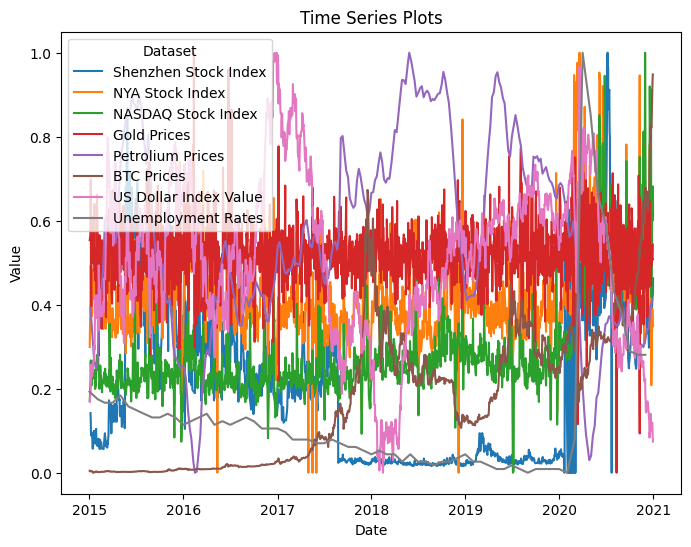

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_datasets(datasets):
    """
    Plots each dataset in the same plot with 'Date' on the x-axis and the last column on the y-axis.

    :param datasets: Dictionary of preprocessed datasets with their names as keys.
    """
    plt.figure(figsize=(8, 6))  # Create a figure

    for name, df in datasets.items():
        last_column = df.columns[-1]  # Assuming the last column is the one to be plotted
        sns.lineplot(data=df, x='Date', y=last_column, label=name)  # Plot each dataset

    plt.title("Time Series Plots")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend(title='Dataset')
    plt.show()

# Run the function for all the datasets
plot_datasets(preprocessed_datasets)

In [14]:
test1 = list(preprocessed_datasets.items())[4]
print(test1)
#plot_datasets(test1)

('Petrolium Prices',            Date        A1
0    2015-01-05  0.393361
1    2015-01-06  0.384351
2    2015-01-07  0.375341
3    2015-01-08  0.366331
4    2015-01-09  0.357321
...         ...       ...
2180 2020-12-24  0.402608
2181 2020-12-25  0.404861
2182 2020-12-26  0.407113
2183 2020-12-27  0.409366
2184 2020-12-28  0.411618

[2185 rows x 2 columns])


## Dynamic Time Warping (DTW)

In [15]:
def compare_datasets_with_dtw(datasets, plot_alignments=False):
    """
    Compares each dataset to every other dataset using Dynamic Time Warping (DTW).
    Assumes the column of interest is the last one in each dataset. Optionally plots the alignments.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :param plot_alignments: Boolean, whether to plot the time series alignments.
    :return: A DataFrame of DTW distances between each pair of datasets.
    """
    # Extract the last column from each dataset
    sequences = [df.iloc[:, -1].values for df in datasets.values()]

    # Compute the DTW distance matrix
    distance_matrix = dtw.distance_matrix_fast(sequences)

    dataset_names = list(datasets.keys())
    return pd.DataFrame(distance_matrix, index=dataset_names, columns=dataset_names)

# Use the function on the preprocessed datasets and plot alignments
dtw_df = compare_datasets_with_dtw(preprocessed_datasets, plot_alignments=True)


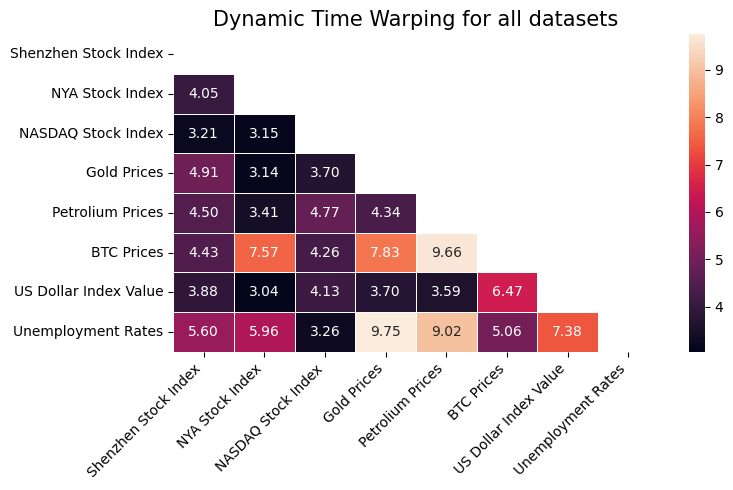

In [16]:
plt.figure(figsize=(8, 5))
mask = np.triu(np.ones_like(dtw_df, dtype=bool))
sns.heatmap(dtw_df, annot=True, fmt=".2f", linewidths=.5, cbar=True, mask=mask)
plt.title("Dynamic Time Warping for all datasets", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Cross-correlation

In [17]:
def compare_datasets_with_cross_correlation(datasets):
    """
    Compares each dataset to every other dataset using cross-correlation.
    Assumes the column of interest is the last one in each dataset.

    :param datasets: Dictionary of Pandas DataFrames, each representing a time series dataset.
    :return: A DataFrame of cross-correlation scores between each pair of datasets.
    """
    dataset_names = list(datasets.keys())
    n = len(dataset_names)
    cross_corr_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i + 1, n):
            # Extract the last column from each dataset for comparison
            series_i = datasets[dataset_names[i]].iloc[:, -1].dropna().values
            series_j = datasets[dataset_names[j]].iloc[:, -1].dropna().values

            # Compute cross-correlation
            corr = correlate(series_i, series_j, mode='full')
            max_corr = np.max(corr)
            cross_corr_matrix[i, j] = cross_corr_matrix[j, i] = max_corr

    return pd.DataFrame(cross_corr_matrix.round(2), index=dataset_names, columns=dataset_names)

cross_corr_df = compare_datasets_with_cross_correlation(preprocessed_datasets)

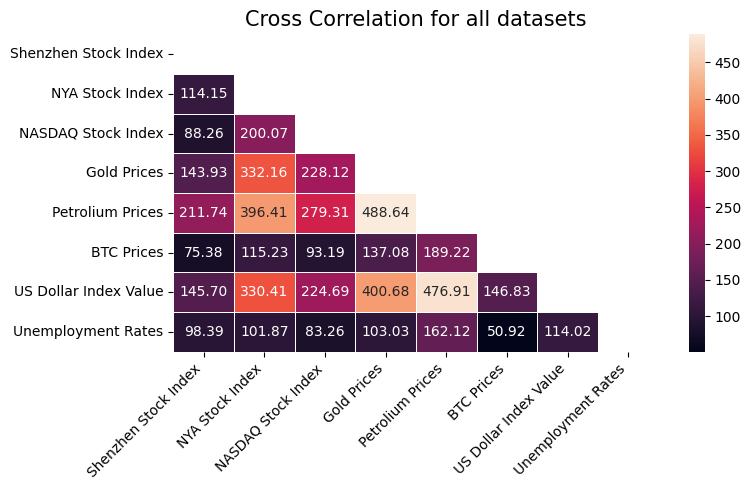

In [18]:
plt.figure(figsize=(8, 5))
mask = np.triu(np.ones_like(dtw_df, dtype=bool))
sns.heatmap(cross_corr_df, annot=True, fmt=".2f", linewidths=.5, cbar=True, mask=mask)
plt.title("Cross Correlation for all datasets", fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Test-Train split

In [19]:
def prepare_data(df, time_steps=1):
    """
    Converts the DataFrame into two arrays X and y, where X is an array of sequences of past observations
    and y is the array of corresponding future values that we want to predict.
    """
    df = df.iloc[:, -1].values  # Using only the last column
    df = df.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    df = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df[i-time_steps:i, 0])
        y.append(df[i, 0])

    return np.array(X), np.array(y)

# Function to split datasets into train and test
def split_datasets(datasets, time_steps, test_size=0.2):
    train_test_split_datasets = {}
    for name, df in datasets.items():
        X, y = prepare_data(df, time_steps)
        X = X.reshape(X.shape[0], X.shape[1], 1)
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
        train_test_split_datasets[name] = (train_X, train_y, test_X, test_y)
    return train_test_split_datasets

## RNN

### TL without fine-tuning

In [20]:
preprocessed_datasets = preprocess_datasets(datasets, scaled=False)

_________________________________________________
Preprocessing Shenzhen Stock Index
There are 168 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NYA Stock Index
There are 1 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing NASDAQ Stock Index
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Gold Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing Petrolium Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing BTC Prices
There are 0 NA values in the dataset. 0 after removing them.
_________________________________________________
Preprocessing US Dollar Index Value
There are 0 NA values in the dataset. 0 after removing them.
_____

In [21]:
# Function to prepare data
def prepare_data(df, time_steps=1):
    """
    Converts DataFrame into X, y arrays without scaling.
    """
    df = df.iloc[:, -1].values  # Using only the last column
    df = df.reshape(-1, 1)

    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df[i-time_steps:i, 0])
        y.append(df[i, 0])

    return np.array(X), np.array(y)

# Function to split datasets into train and test and scale data
def split_datasets(datasets, time_steps, test_size=0.2):
    train_test_split_datasets = {}
    scalers = {}
    for name, df in datasets.items():
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scaled = scaler.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))

        X, y = prepare_data(pd.DataFrame(df_scaled), time_steps)
        X = X.reshape(X.shape[0], X.shape[1], 1)
        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)

        train_test_split_datasets[name] = (train_X, train_y, test_X, test_y)
        scalers[name] = scaler

    return train_test_split_datasets, scalers

# Function to create an RNN model
def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train the RNN model using transfer learning
def train_with_transfer_learning(split_datasets, base_model=None):
    trained_models = {}
    for name, (train_X, train_y, test_X, test_y) in split_datasets.items():
        print(f"Training on {name}")

        # If it's the first model, create a new one; otherwise, use the base model
        if base_model is None:
            model = create_rnn_model(train_X.shape[1:])  # input_shape is the shape of X excluding the sample axis
        else:
            model = tf.keras.models.clone_model(base_model)
            # Re-compile the model after cloning
            model.compile(optimizer='adam', loss='mean_squared_error')

        early_stopping = EarlyStopping(monitor='val_loss', patience=15)
        model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=10, callbacks=[early_stopping])

        trained_models[name] = model
        base_model = model  # Update the base model for transfer learning

    return trained_models

# Define time_steps
time_steps = 5  # Adjust based on your datasets

# Split the datasets and get scalers
split_data, scalers = split_datasets(preprocessed_datasets, time_steps)

# Train the models using transfer learning
trained_models = train_with_transfer_learning(split_data)

# Function to evaluate models on test data
def evaluate_models_on_test_data(trained_models, split_datasets, scalers):
    evaluation_results = {}
    for train_name, model in trained_models.items():
        evaluation_results[train_name] = {}
        for test_name, (test_X, test_y, _, _) in split_datasets.items():
            predictions = model.predict(test_X)

            # Inverse scaling predictions
            predictions = scalers[test_name].inverse_transform(predictions)
            test_y_unscaled = scalers[test_name].inverse_transform(test_y.reshape(-1, 1))

            evaluation_results[train_name][test_name] = {
                'MSE': mean_squared_error(test_y_unscaled, predictions),
                'RMSE': np.sqrt(mean_squared_error(test_y_unscaled, predictions)),
                'MAE': mean_absolute_error(test_y_unscaled, predictions),
                'R2': r2_score(test_y_unscaled, predictions)
            }

    return evaluation_results

# Evaluate the models on test data
evaluation_results = evaluate_models_on_test_data(trained_models, split_data, scalers)


Training on Shenzhen Stock Index
Epoch 1/10
55/55 [==============================] - 16s 95ms/step - loss: 0.0083 - val_loss: 0.0158
Epoch 2/10
55/55 [==============================] - 1s 16ms/step - loss: 0.0024 - val_loss: 0.0157
Epoch 3/10
55/55 [==============================] - 1s 16ms/step - loss: 0.0023 - val_loss: 0.0181
Epoch 4/10
55/55 [==============================] - 1s 21ms/step - loss: 0.0025 - val_loss: 0.0147
Epoch 5/10
55/55 [==============================] - 1s 14ms/step - loss: 0.0021 - val_loss: 0.0165
Epoch 6/10
55/55 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0151
Epoch 7/10
55/55 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0142
Epoch 8/10
55/55 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0145
Epoch 9/10
55/55 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0139
Epoch 10/10
55/55 [==============================] - 1s 10ms/step - loss: 0

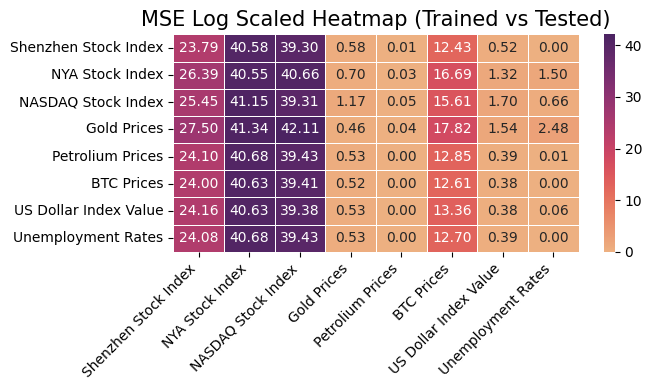

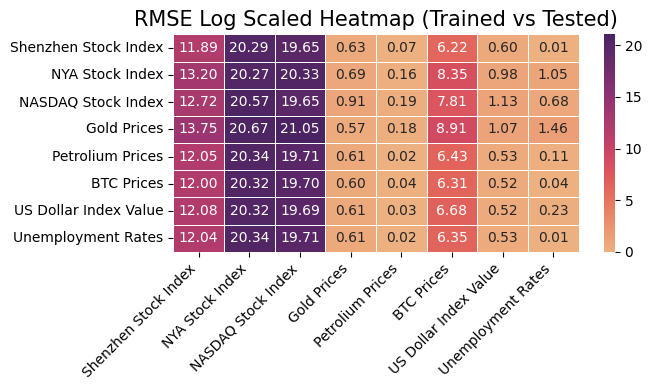

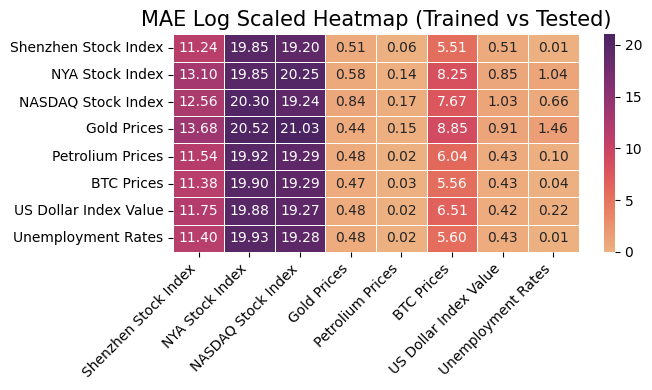

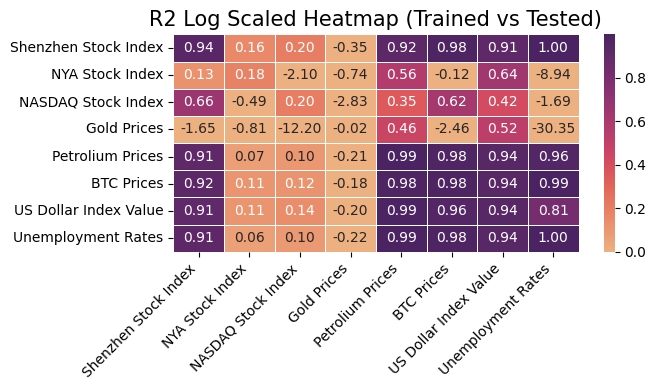

In [22]:
# Initialize empty DataFrames for each metric
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
metric_dfs = {metric: pd.DataFrame(index=evaluation_results.keys(), columns=evaluation_results.keys()) for metric in metrics}

# Populate the DataFrames with evaluation results
for train_name in evaluation_results:
    for test_name in evaluation_results[train_name]:
        for metric in metrics:
            value = evaluation_results[train_name][test_name][metric]
            metric_dfs[metric].loc[train_name, test_name] = np.log1p(value) if metric != 'R2' else value  # Apply log scale for error metrics

# Convert all values to numeric
for metric in metrics:
    metric_dfs[metric] = metric_dfs[metric].apply(pd.to_numeric, errors='coerce')

# Generate heatmaps for each metric
def generate_heatmap(df, title, is_r2=False):
    plt.figure(figsize=(7, 4))
    vmax = None if is_r2 else df.max().max()  # Set a max value for color scale if not R2
    sns.heatmap(df, annot=True, fmt=".2f", linewidths=.5, cbar=True, vmin=0, vmax=vmax, cmap='flare')
    plt.title(title, fontsize=15)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

for metric, df in metric_dfs.items():
    generate_heatmap(df, f"{metric} Log Scaled Heatmap (Trained vs Tested)", is_r2=(metric == 'R2'))


### TL with fine-tuning

In [23]:
# Function to fine-tune a model on a specific dataset
def fine_tune_model(model, fine_tune_X, fine_tune_y, epochs=5):
    model.fit(fine_tune_X, fine_tune_y, epochs=epochs, verbose=0)  # Verbose=0 to reduce log clutter
    return model

# Modified function to evaluate models on test data with fine-tuning
def evaluate_models_on_test_data_with_fine_tuning(trained_models, split_datasets, scalers, fine_tune_epochs=5):
    evaluation_results = {}
    for train_name, model in trained_models.items():
        evaluation_results[train_name] = {}
        for test_name, (train_X, train_y, test_X, test_y) in split_datasets.items():
            # Fine-tune the model on a portion of the target dataset
            fine_tuned_model = fine_tune_model(model, train_X, train_y, epochs=fine_tune_epochs)

            # Make predictions with the fine-tuned model
            predictions = fine_tuned_model.predict(test_X)

            # Inverse scaling predictions
            predictions = scalers[test_name].inverse_transform(predictions)
            test_y_unscaled = scalers[test_name].inverse_transform(test_y.reshape(-1, 1))

            evaluation_results[train_name][test_name] = {
                'MSE': mean_squared_error(test_y_unscaled, predictions),
                'RMSE': np.sqrt(mean_squared_error(test_y_unscaled, predictions)),
                'MAE': mean_absolute_error(test_y_unscaled, predictions),
                'R2': r2_score(test_y_unscaled, predictions)
            }

    return evaluation_results

# Evaluate the models on test data with fine-tuning
evaluation_results_fine_tuned = evaluate_models_on_test_data_with_fine_tuning(trained_models, split_data, scalers, fine_tune_epochs=5)


14/14 [==============================] - 0s 3ms/step


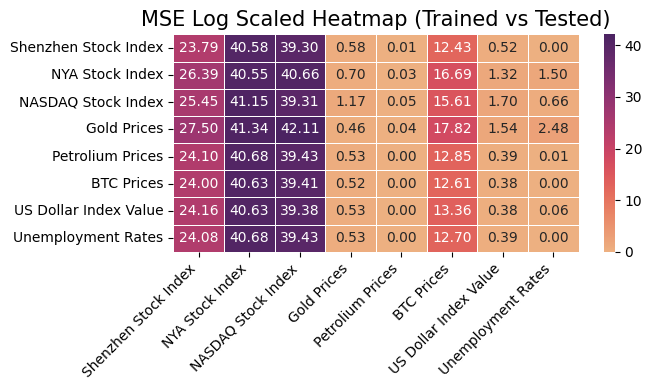

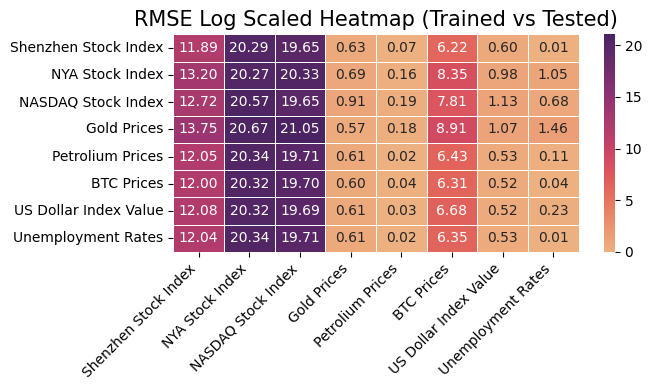

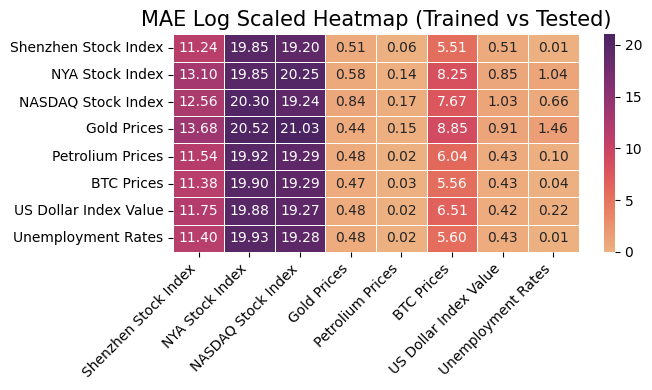

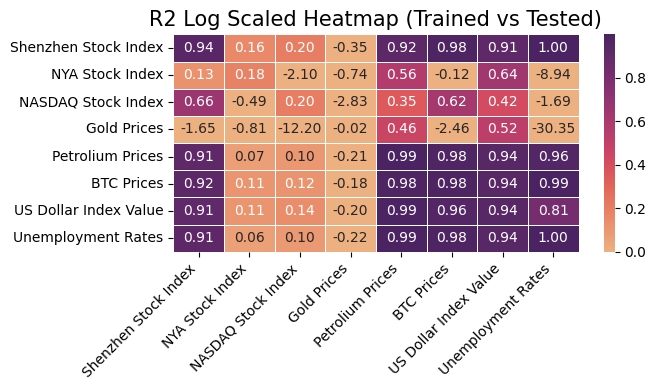

In [24]:
# Initialize empty DataFrames for each metric
metrics = ['MSE', 'RMSE', 'MAE', 'R2']
metric_dfs = {metric: pd.DataFrame(index=evaluation_results.keys(), columns=evaluation_results.keys()) for metric in metrics}

# Populate the DataFrames with evaluation results
for train_name in evaluation_results:
    for test_name in evaluation_results[train_name]:
        for metric in metrics:
            value = evaluation_results[train_name][test_name][metric]
            metric_dfs[metric].loc[train_name, test_name] = np.log1p(value) if metric != 'R2' else value  # Apply log scale for error metrics

# Convert all values to numeric
for metric in metrics:
    metric_dfs[metric] = metric_dfs[metric].apply(pd.to_numeric, errors='coerce')

for metric, df in metric_dfs.items():
    generate_heatmap(df, f"{metric} Log Scaled Heatmap (Trained vs Tested)", is_r2=(metric == 'R2'))



## MLP

### TL without fine-tuning

In [25]:
def split_train_test(df, test_size=0.2):
    """
    Chronologically splits the DataFrame into training and testing sets.

    :param df: DataFrame to split.
    :param test_size: Proportion of the dataset to include in the test split.
    :return: train_df, test_df
    """
    split_index = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    return train_df, test_df

def create_mlp_model(input_shape):
    """
    Creates a shallow MLP model.

    :param input_shape: Shape of the input data.
    :return: Compiled MLP model.
    """
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_ensemble_models(datasets, create_model_func, epochs=25):
    trained_models = {}
    base_model_weights = None

    for name, df in datasets.items():
        print(f"Training on {name}")

        X = df.drop('Date', axis=1).values
        y = df.iloc[:, -1].values

        train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=False)

        if base_model_weights is None:
            model = create_model_func(input_shape=(train_X.shape[1],))
            base_model_weights = model.get_weights()
        else:
            model.set_weights(base_model_weights)

        model.fit(train_X, train_y, epochs=epochs)
        trained_models[name] = (model, test_X, test_y)

    return trained_models

def evaluate_models(trained_models):
    evaluation_results = pd.DataFrame(columns=trained_models.keys(), index=trained_models.keys())

    for train_name, (model, _, _) in trained_models.items():
        for test_name, (_, test_X, test_y) in trained_models.items():
            predictions = model.predict(test_X)
            mse = mean_squared_error(test_y, predictions)
            evaluation_results.loc[train_name, test_name] = np.log1p(mse)  # Apply log scale for MSE

    return evaluation_results

trained_models = train_ensemble_models(preprocessed_datasets, create_mlp_model)
evaluation_results = evaluate_models(trained_models)



Training on Shenzhen Stock Index
Epoch 1/25
55/55 [==============================] - 1s 2ms/step - loss: 514564161536.0000
Epoch 2/25
55/55 [==============================] - 0s 2ms/step - loss: 99299164160.0000
Epoch 3/25
55/55 [==============================] - 0s 2ms/step - loss: 5490090496.0000
Epoch 4/25
55/55 [==============================] - 0s 2ms/step - loss: 28765862.0000
Epoch 5/25
55/55 [==============================] - 0s 2ms/step - loss: 50661.3867
Epoch 6/25
55/55 [==============================] - 0s 2ms/step - loss: 58.0222
Epoch 7/25
55/55 [==============================] - 0s 2ms/step - loss: 0.7060
Epoch 8/25
55/55 [==============================] - 0s 2ms/step - loss: 0.2944
Epoch 9/25
55/55 [==============================] - 0s 2ms/step - loss: 0.2927
Epoch 10/25
55/55 [==============================] - 0s 2ms/step - loss: 0.2911
Epoch 11/25
55/55 [==============================] - 0s 2ms/step - loss: 0.2905
Epoch 12/25
55/55 [==============================] - 0

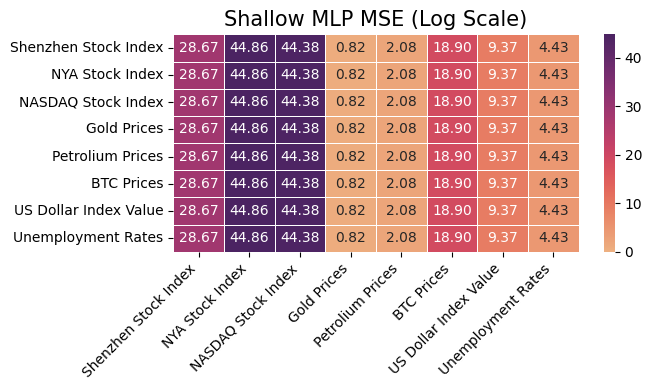

In [26]:
evaluation_results = evaluation_results.apply(pd.to_numeric, errors='coerce')
generate_heatmap(evaluation_results, 'Shallow MLP MSE (Log Scale)')

### TL with fine-tuning

In [27]:
def split_train_test_finetune(df, test_size=0.2, fine_tune_size=0.1):
    """
    Splits the DataFrame into training, fine-tuning, and testing sets chronologically.
    """
    fine_tune_index = int(len(df) * (1 - fine_tune_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    train_df = df.iloc[:fine_tune_index]
    fine_tune_df = df.iloc[fine_tune_index:test_index]
    test_df = df.iloc[test_index:]
    return train_df, fine_tune_df, test_df

def train_ensemble_models(datasets, create_model_func, epochs=25, fine_tune_epochs=5):
    trained_models = {}
    base_model_weights = None

    for name, df in datasets.items():
        print(f"Training on {name}")

        # Split the dataset
        train_df, fine_tune_df, test_df = split_train_test_finetune(df)

        # Prepare the data
        train_X = train_df.drop('Date', axis=1).values
        train_y = train_df.iloc[:, -1].values

        fine_tune_X = fine_tune_df.drop('Date', axis=1).values
        fine_tune_y = fine_tune_df.iloc[:, -1].values

        test_X = test_df.drop('Date', axis=1).values
        test_y = test_df.iloc[:, -1].values

        # Create model
        if base_model_weights is None:
            model = create_model_func(input_shape=(train_X.shape[1],))
            base_model_weights = model.get_weights()
        else:
            model.set_weights(base_model_weights)

        # Train model
        model.fit(train_X, train_y, epochs=epochs)

        # Fine-tune model on each dataset
        fine_tuned_models = {}
        for ft_name, ft_df in datasets.items():
            ft_train_df, ft_fine_tune_df, _ = split_train_test_finetune(ft_df)
            ft_X = ft_fine_tune_df.drop('Date', axis=1).values
            ft_y = ft_fine_tune_df.iloc[:, -1].values
            model.fit(ft_X, ft_y, epochs=fine_tune_epochs)
            fine_tuned_models[ft_name] = (model, test_X, test_y)

        trained_models[name] = fine_tuned_models

    return trained_models

# Train the models
trained_models = train_ensemble_models(preprocessed_datasets, create_mlp_model)

# Function to evaluate fine-tuned models
def evaluate_fine_tuned_models(trained_models):
    evaluation_results = pd.DataFrame(columns=trained_models.keys(), index=trained_models.keys())

    for train_name, fine_tuned_models in trained_models.items():
        for test_name, (model, test_X, test_y) in fine_tuned_models.items():
            predictions = model.predict(test_X)
            mse = mean_squared_error(test_y, predictions)
            evaluation_results.loc[train_name, test_name] = np.log1p(mse)  # Apply log scale for MSE

    return evaluation_results

# Evaluate the models
evaluation_results = evaluate_fine_tuned_models(trained_models)


Training on Shenzhen Stock Index
Epoch 1/25
48/48 [==============================] - 1s 3ms/step - loss: 463795716096.0000
Epoch 2/25
48/48 [==============================] - 0s 2ms/step - loss: 172160434176.0000
Epoch 3/25
48/48 [==============================] - 0s 2ms/step - loss: 36211785728.0000
Epoch 4/25
48/48 [==============================] - 0s 2ms/step - loss: 2996177920.0000
Epoch 5/25
48/48 [==============================] - 0s 2ms/step - loss: 72661840.0000
Epoch 6/25
48/48 [==============================] - 0s 2ms/step - loss: 214878.9531
Epoch 7/25
48/48 [==============================] - 0s 2ms/step - loss: 1250.1565
Epoch 8/25
48/48 [==============================] - 0s 2ms/step - loss: 6.5376
Epoch 9/25
48/48 [==============================] - 0s 2ms/step - loss: 0.2876
Epoch 10/25
48/48 [==============================] - 0s 2ms/step - loss: 0.2765
Epoch 11/25
48/48 [==============================] - 0s 2ms/step - loss: 0.2637
Epoch 12/25
48/48 [=====================

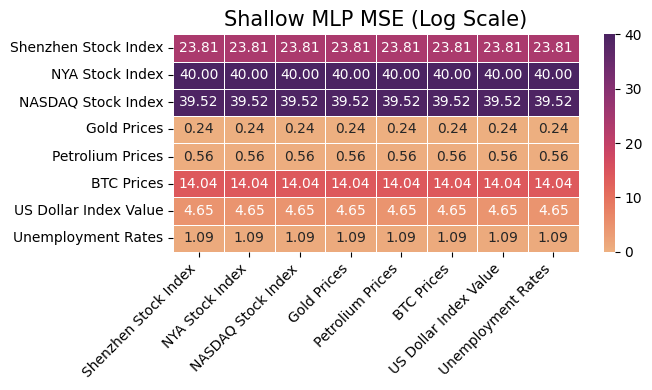

In [28]:
evaluation_results = evaluation_results.apply(pd.to_numeric, errors='coerce')
generate_heatmap(evaluation_results, 'Shallow MLP MSE (Log Scale)')